In [1]:
from qutip import *
import matplotlib.pyplot as plt
import numpy as np
from helper_code_qutip import *
from scipy import integrate
import scipy.io

In [22]:
NL1 = 2
NL2 = 2
NM = 2

N = NL1 + NL2 + NM
beta_1 = 1.5
dL1 = 2**NL1
dL2 = 2**NL2
dM = 2**NM
d = dL1*dL2*dM
dims = [2]*N


w0list = np.linspace(1,1,N)
delta = 1
deltalist = np.linspace(delta,delta,N)
g = 1.6e-3
glist = np.linspace(g,g,N-1)

p_h = 1
p_c = 1

epsilon = 0.01

In [37]:
def concurrence_plot(beta_list,reduced_dm_list):
    concurrence_list = []
    for i in range(len(beta_list)):
       
        
        concurrence_list.append(concurrence(reduced_dm_list[i]))
            #print(f'Concurrence Qutip for Tc = {Tc_list[i]} and Th = {round(Th_list[j],2)}: ',concurrence(reduced_dm_list[i][j]))
    plt.plot(beta_list,concurrence_list,label='Th/Eh = '+str(1/1.5))
        ##save the data
    np.save(f'CVX_data/concurrence_data_noneq_beta1 = 1.5',concurrence_list)

    plt.xlabel('beta2')
    plt.ylabel('Concurrence')
    plt.title(f'Concurrence (CVX) for different Th at g = {g}, ph = {p_h}, pc = {p_c}')
    plt.legend()

    plt.show()


def negativity1(rho):
    a1 = rho[0,0]
    a4 = rho[3,3]
    c = np.abs(rho[1,2])
    val = 0.5*(np.sqrt(4*c**2 + (a1-a4)**2) - (a1+a4))  #How did it know the function?? Very cool
    if val < 0:
        return 0
    else:
        return val

def negativity_plot(beta_list,reduced_dm_list):
    concurrence_list = []
    for i in range(len(beta_list)):
        
        
        concurrence_list.append(negativity1(reduced_dm_list[i]))
            #print(f'Concurrence Qutip for Tc = {Tc_list[i]} and Th = {round(Th_list[j],2)}: ',concurrence(reduced_dm_list[i][j]))
    plt.plot(beta_list,concurrence_list,label='Th/Eh = '+str(1/1.5))
        ##save the data
    np.save(f'CVX_data/negativity_data_noneq_beta1 = 1.5',concurrence_list)
    plt.xlabel('beta2')
    plt.ylabel('Negativity')
    plt.title(f'Negativity for different Th at g = {g}, ph = {p_h}, pc = {p_c}')
    plt.legend()

    plt.show()

    ## Let us plot heat current as well

def thermal_h(E,T_h):
    r_c = 1/(1+np.exp(-E/T_h))
    t_h = r_c*fock_dm(2,1) + (1-r_c)*fock_dm(2,0)

    return t_h

def heat_current(betalist,reduced_dm_list):
    
    heat_curr_list = []
    for j in range(len(betalist)):
        ss = reduced_dm_list[j]
        rho_h = ss.ptrace(0)
        thermal_cold = thermal_h(1.0,1/1.5)

        heat_curr = -p_h*(fock(2,0).dag()*(rho_h - thermal_cold)*fock(2,0))  #as |0> is the excited state

        heat_curr_list.append(heat_curr.real)
    plt.plot(betalist,heat_curr_list,label='Th/Eh = '+str(1/1.5))
    np.save(f'CVX_data/heat_current_data_noneq_beta1 = 1.5',heat_curr_list)
    
    plt.xlabel('beta2')
    plt.ylabel('Heat current')
    plt.title(f'Heat current (CVX) for different Th at g = {g}, ph = {p_h}, pc = {p_c}')
    plt.legend()

    plt.show()

In [3]:
def matrix_transform(dL,gamma_matrix,ls_matrix):
    gamma_matr = np.zeros((dL**2-1,dL**2-1), dtype = complex)
    ls_matr = np.zeros((dL,dL), dtype = complex)

    for i in range(dL**2-1):
        for j in range(dL**2-1):
            gamma_matr[i,j] = gamma_matrix[i,j]

    for i in range(dL):
        for j in range(dL):
            ls_matr[i,j] = ls_matrix[i,j]

    return gamma_matr, ls_matr

In [14]:
matlab_data3 = scipy.io.loadmat('../matlab/data_plotting_vsbeta_2/thermal_data_new1_th.mat',mat_dtype=False)  # is set to True, givex complex casting to real errors..
matlab_F_list1 = matlab_data3["F1"]
F_list1 = []

matlab_F_list2 = matlab_data3["F2"]
F_list2 = []


for index in range(2**dL1):
    matrix1 = np.asmatrix(matlab_F_list1[0,index])
    matrix2 = np.asmatrix(matlab_F_list2[0,index])

    F_list1.append(Qobj(matrix1))
    F_list2.append(Qobj(matrix2))
    
if not basis_is_orthonormal(F_list1):
    print("WARNING : Basis 1 is NOT orthonormal")

if not basis_is_orthonormal(F_list2):
    print("WARNING : Basis 2 is NOT orthonormal")

F_list1.pop() #removes the last indentity basis ..
print(F_list2[-1]) # should be identity matrix
F_list2.pop()

for index in range(2**dL1-1):
    F_list1[index].dims = [dims,dims] # makes sure mutliplication will work and QuTiP wont throw errors. 
    F_list2[index].dims = [dims,dims]

Quantum object: dims=[[64], [64]], shape=(64, 64), type='oper', dtype=Dense, isherm=True
Qobj data =
[[0.125 0.    0.    ... 0.    0.    0.   ]
 [0.    0.125 0.    ... 0.    0.    0.   ]
 [0.    0.    0.125 ... 0.    0.    0.   ]
 ...
 [0.    0.    0.    ... 0.125 0.    0.   ]
 [0.    0.    0.    ... 0.    0.125 0.   ]
 [0.    0.    0.    ... 0.    0.    0.125]]


In [27]:
def steady_state_calc(H_S,beta1, beta2, gamma_matrix1, gamma_matrix2, ls_matrix1, ls_matrix2):

    
    [D1,U1] = np.linalg.eigh(gamma_matrix1)
    [D2,U2] = np.linalg.eigh(gamma_matrix2)

    L_list1 = []
    Udagger1 = np.transpose(np.conj(U1))
    L_list2 = []
    Udagger2 = np.transpose(np.conj(U2))

    for j  in range(dL1**2-1):
        op1 = 0
        op2 = 0
        for betaindex in range(dL1**2-1):    
            op1 = op1+Udagger1[j,betaindex]* F_list1[betaindex]
            op2 = op2+Udagger2[j,betaindex]* F_list2[betaindex]
        L_list1.append(op1)
        L_list2.append(op2)

    tildeL_list1 = []
    tildeL_list2 = []

    for index in range(dL1**2-1):
        tildeL_list1.append(np.sqrt(p_h*D1[index])*L_list1[index])
        tildeL_list2.append(np.sqrt(p_c*D2[index])*L_list2[index])

    tildeL_list = []
    for i in tildeL_list1:
        tildeL_list.append(i)

    for i in tildeL_list2:
        tildeL_list.append(i)

    H_LS1 = tensor(Qobj(ls_matrix1),qeye(dM*dL2))
    H_LS2 = tensor(qeye(dL1*dM),Qobj(ls_matrix2))
    #print(dims)
    #print(H_LS1.dims)
    H_LS1.dims = [dims,dims]
    H_LS2.dims = [dims,dims]
    
    L_operator = liouvillian(H_S+H_LS1+H_LS2, tildeL_list)
    rho_ss = steadystate(L_operator)

    L_eigen = L_operator.eigenenergies()

    print("Smallest eigenvalues for Th = ",1/beta1,"and Tc = ",1/beta2, "are ",L_eigen[-3:])

    return rho_ss

In [17]:
## We first load the data from the .mat file
H_LS1_list = []
H_LS2_list = []
Gamma1_list = []
Gamma2_list = []
betalist = [1.0,1.2,1.5,1.7,2.0,2.2,2.4,2.7,3,3.5]
for i in range(1,len(betalist)+1):
    matlab_data = scipy.io.loadmat(f'../matlab/data_plotting_vsbeta_2/thermal_data2_new{i}.mat',mat_dtype=False)
    gamma1,h_ls1 = matrix_transform(dL1,matlab_data['gamma_matrix1'],matlab_data['H_LS1'])
    gamma2,h_ls2 = matrix_transform(dL2,matlab_data['gamma_matrix2'],matlab_data['H_LS2'])
    Gamma1_list.append(gamma1)
    Gamma2_list.append(gamma2)
    H_LS1_list.append(h_ls1)
    H_LS2_list.append(h_ls2)
    


In [19]:
print(H_LS1_list[0].shape)
print(Gamma1_list[0].shape)

(4, 4)
(15, 15)


In [28]:
#Now we will calculate the steady states for each of the temperatures
cvx_ss = []
for i in range(len(betalist)):
    H_S = create_hamiltonian(w0list,glist,delta,N)
    rho_ss = steady_state_calc(H_S,beta_1,betalist[i],Gamma1_list[i],Gamma2_list[i],H_LS1_list[i],H_LS2_list[i])
    #rho_ss.dims = [dims,dims]
    rho_ss = rho_ss.ptrace([2,3])
    cvx_ss.append(rho_ss)
    

Smallest eigenvalues for Th =  0.6666666666666666 and Tc =  1.0 are  [-4.37480346e-04-1.01139798e+00j -2.86722024e-04+8.39620829e-16j
 -5.27498379e-16+1.30557158e-15j]
Smallest eigenvalues for Th =  0.6666666666666666 and Tc =  0.8333333333333334 are  [-4.24535222e-04+1.01138810e+00j -3.04820265e-04-3.69959801e-16j
 -2.39817836e-15+8.12996378e-16j]
Smallest eigenvalues for Th =  0.6666666666666666 and Tc =  0.6666666666666666 are  [-3.92060607e-04-1.01140872e+00j -3.05232895e-04-4.44584281e-16j
 -1.01273506e-15-4.13737824e-16j]
Smallest eigenvalues for Th =  0.6666666666666666 and Tc =  0.5882352941176471 are  [-3.50232717e-04-1.00088026e+00j -3.25096034e-04+1.27900388e-15j
 -9.18196912e-16+6.45614306e-15j]
Smallest eigenvalues for Th =  0.6666666666666666 and Tc =  0.5 are  [-3.48732108e-04+1.00092084e+00j -3.01940867e-04+2.96299440e-15j
 -6.11897392e-16+2.74135676e-15j]
Smallest eigenvalues for Th =  0.6666666666666666 and Tc =  0.45454545454545453 are  [-3.32786666e-04+1.00093676e+0

In [29]:
print(cvx_ss[0])

Quantum object: dims=[[2, 2], [2, 2]], shape=(4, 4), type='oper', dtype=Dense, isherm=True
Qobj data =
[[ 5.39496830e-02+0.00000000e+00j -3.18316104e-13+4.36906869e-10j
  -1.91761071e-13+4.23554954e-10j -9.49416633e-18-2.61787195e-17j]
 [-3.18316104e-13-4.36906869e-10j  1.77816789e-01+0.00000000e+00j
   6.70241098e-04-3.95398735e-05j -1.26951737e-12+1.40130609e-09j]
 [-1.91761071e-13-4.23554954e-10j  6.70241098e-04+3.95398735e-05j
   1.77796917e-01+0.00000000e+00j -3.94358912e-13+1.44526693e-09j]
 [-9.49416633e-18+2.61787195e-17j -1.26951737e-12-1.40130609e-09j
  -3.94358912e-13-1.44526693e-09j  5.90436611e-01+0.00000000e+00j]]


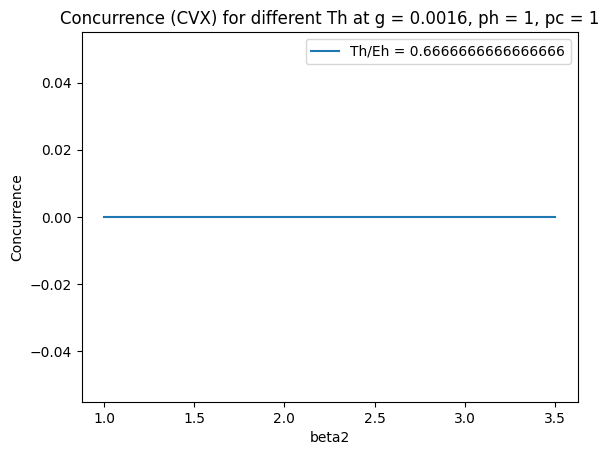

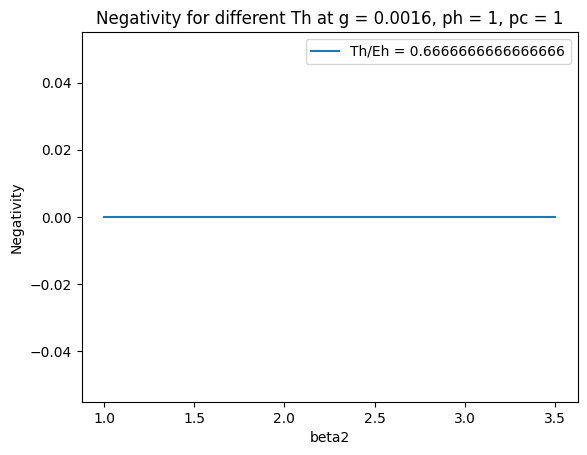

In [36]:
concurrence_plot(betalist,cvx_ss)
negativity_plot(betalist,cvx_ss)

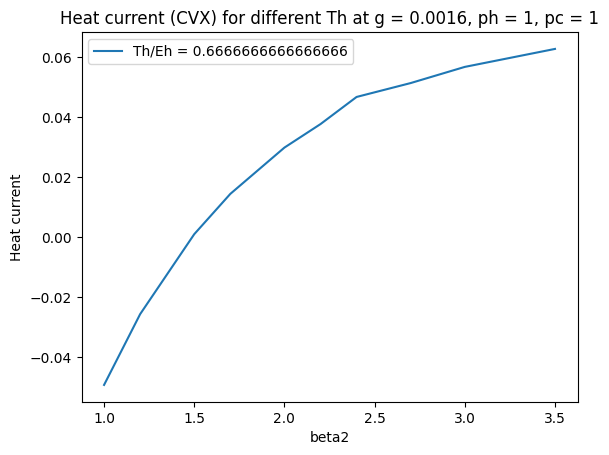

In [38]:
heat_current(betalist,cvx_ss)